# Investigating Hydroshoot Warmup behavior

In [1]:
"""Configure data sources"""

EXPERIMENT_ROOT = 'F:/thesis-cyborg-plants/results/fixed_predawn_7days_jun_jul_aug'

In [2]:
"""Import general dependencies"""

%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

In [3]:
"""Import own source and configure hot reloading"""

%load_ext autoreload
%reload_ext autoreload
%autoreload 2  # will autoreload all packages imported with %aimport

sys.path.insert(1, os.path.join(sys.path[0], '..'))  # for importing local packages from src


In [4]:
"""Loading dataset"""
from src.model.hydroshoot_experiment import load_runs, HydroShootExperiment

assert(os.path.isdir(EXPERIMENT_ROOT))
runs = load_runs(EXPERIMENT_ROOT)
print(len(runs))
print(runs[0])
print('Targets:', runs[0].get_targets())
print('Variables:', runs[0].get_state_variables())

84
HydroShootExperiment(n_steps=168, state_size=360)
Targets: ('input_Tac', 'input_u', 'input_hs', 'input_Rg', 'output_Rg', 'output_An', 'output_E', 'output_Tleaf')
Variables: ('Ci', 'gb', 'Ei', 'FluxC', 'Tlc', 'An', 'Flux', 'psi_head', 'u', 'E', 'Eabs', 'gs', 'par_photo.dHd')


## Preparing dataset and model

In [71]:
"""Define readout parameters."""

from src.learning.preprocessing import generate_mask

STATE_SIZE = 64
SAMPLES_PER_RUN = 1
N_CV_GROUPS = 4
DAYLIGHT_MASK = generate_mask(5, 21)

In [72]:
"""Define cross-validation folds and grouping strategy."""

from sklearn.model_selection import LeaveOneGroupOut
from src.learning.grouping import group_by_day

generate_groups = group_by_day
folds = LeaveOneGroupOut()

In [73]:
"""Define model pipeline and parameter search grid."""

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e6), 25)
}]

## Evaluating effect of warmup steps on readout score

We will train the model on the entire dataset with increasing warmup day counts (1-6 days) and compare the NMSE.

In [74]:
from src.constants import HYDROSHOOT_STATE_VARIABLES

warmup_steps = [i for i in range(0, 7)]
targets = sorted(runs[0].get_targets())
variables = sorted(HYDROSHOOT_STATE_VARIABLES)

print(warmup_steps)

[0, 1, 2, 3, 4, 5, 6]


In [75]:
from tqdm import tqdm
from src.learning.training import evaluate_for_runs

model_targets = [(target, var) for target in targets for var in variables]
scores = []  # insert lists of model scores per target, var pairing


with tqdm(total = len(warmup_steps) * len(model_targets)) as pbar:
  for start_day in warmup_steps:
    warmup_scores = []  # insert tuples of model and scores
    for target, var in model_targets:
      result = evaluate_for_runs(readout, var, target, runs, N_CV_GROUPS, folds, search_grid, day_range=start_day,
                             state_size=STATE_SIZE, samples_per_run=SAMPLES_PER_RUN, mask=DAYLIGHT_MASK)
      warmup_scores.append(result)
      pbar.update(1)
    scores.append((start_day, warmup_scores))

100%|██████████| 616/616 [07:26<00:00,  1.38it/s]


In [76]:
"""Transform scores structure"""

from collections import  defaultdict

score_dict = defaultdict(lambda : defaultdict(lambda : ([], [])))

for (_, data) in scores:
  for target, var, model, base_score, tuned_score in data:
    means, stds = score_dict[target][var]
    score_mean, score_std = tuned_score[1]  # index 1 = CV score
    means.append(score_mean)
    stds.append(score_std)

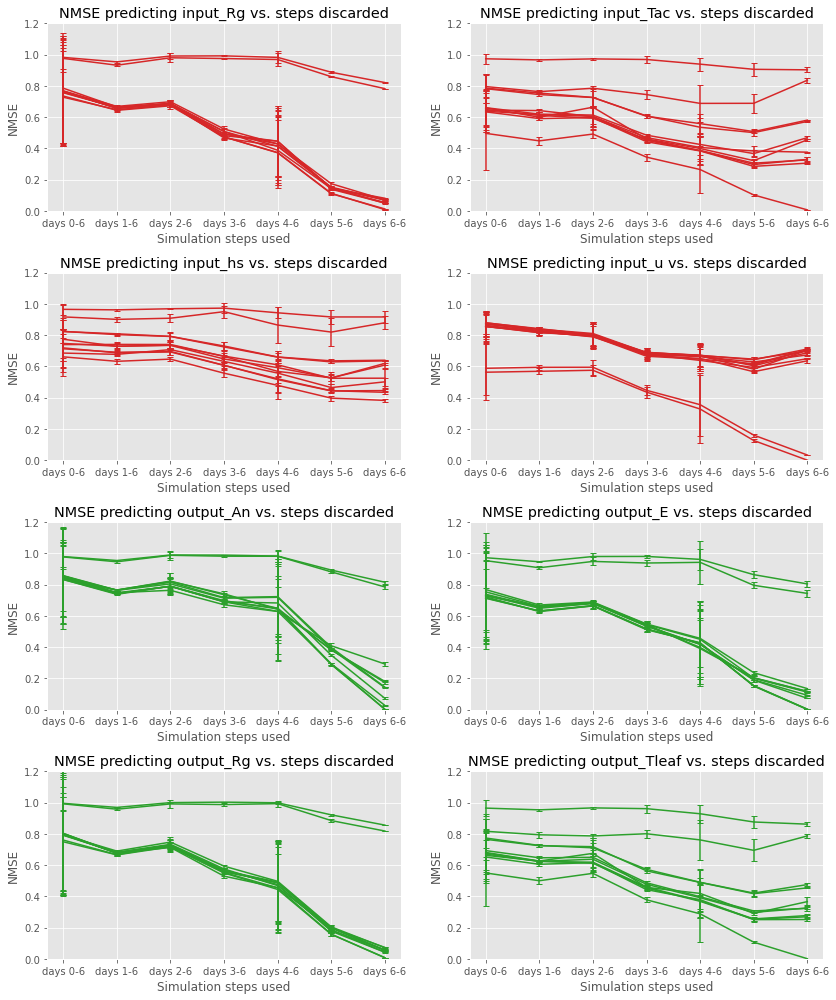

In [77]:
"""Visualize scores"""

target = 'output_Rg'
variable = 'An'

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(4, 2, figsize=(12, 14))

  for i, target in enumerate(targets):
    row = i // 2
    col = i % 2
    color = 'tab:red' if target.startswith('input') else 'tab:green'

    for variable in variables:
      x = np.array(warmup_steps) * 24
      y = -np.array(score_dict[target][variable][0])
      yerr = np.array(score_dict[target][variable][1]) * 1.96 / np.sqrt(N_CV_GROUPS)
      ax[row, col].errorbar(x, y, yerr=yerr, capsize=3, c=color)
      ax[row, col].set_xticks(x)
      ax[row, col].set_xticklabels([f'days {x}-6' for x in warmup_steps])
      ax[row, col].set_xlabel('Simulation steps used')
      ax[row, col].set_ylabel('NMSE')
      ax[row, col].set_title(f'NMSE predicting {target} vs. steps discarded')
      ax[row, col].set_ylim(0, 1.2)

  plt.tight_layout()
  plt.show()

## Evaluating effect of simulation window on readout score

**Hypothesis**: 

the reservoir stationarity is violated because the reservoir dynamics change as the simulation goes on.

**Experiment**:

Train the readout over a shifting window of the simulated days.

In [78]:
# NOTE: the results above show that the score is often
# the best when only the 7th simulation day is used. 

WINDOW_SIZE = 2  

In [79]:
from src.constants import HYDROSHOOT_STATE_VARIABLES

simulation_windows = [(i, i + WINDOW_SIZE) for i in range(0, 7 - WINDOW_SIZE + 1)]
targets = sorted(runs[0].get_targets())
variables = sorted(HYDROSHOOT_STATE_VARIABLES)

print(simulation_windows)

[(0, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7)]


In [80]:
from tqdm import tqdm
from src.learning.training import evaluate_for_runs

model_targets = [(target, var) for target in targets for var in variables]
scores = []  # insert lists of model scores per target, var pairing


with tqdm(total = len(simulation_windows) * len(model_targets)) as pbar:
  for (start, end) in simulation_windows:
    warmup_scores = []  # insert tuples of model and scores
    for target, var in model_targets:
      result = evaluate_for_runs(readout, var, target, runs, N_CV_GROUPS, folds, search_grid, day_range=(start, end),
                             state_size=STATE_SIZE, samples_per_run=SAMPLES_PER_RUN, mask=DAYLIGHT_MASK)
      warmup_scores.append(result)
      pbar.update(1)
    scores.append((start_day, warmup_scores))

100%|██████████| 528/528 [06:03<00:00,  1.45it/s]


In [81]:
"""Transform scores structure"""

from collections import  defaultdict

score_dict = defaultdict(lambda : defaultdict(lambda : ([], [])))

for (_, data) in scores:
  for target, var, model, base_score, tuned_score in data:
    means, stds = score_dict[target][var]
    score_mean, score_std = tuned_score[1]  # index 1 = CV score
    means.append(score_mean)
    stds.append(score_std)

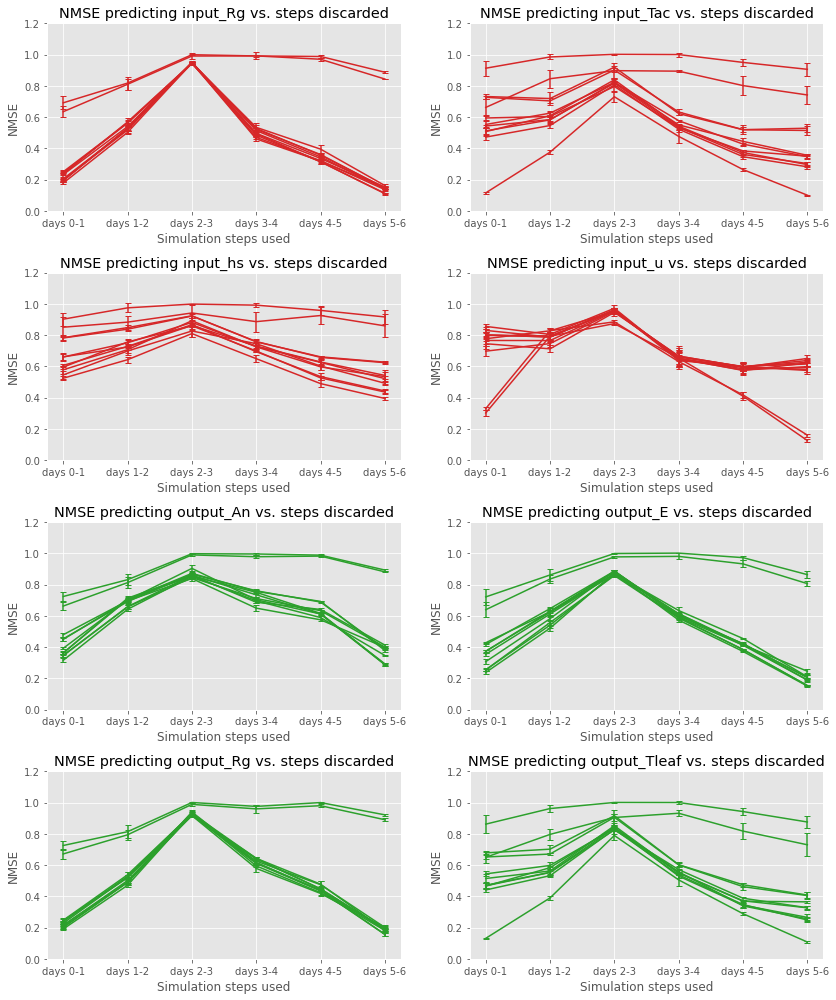

In [82]:
"""Visualize scores"""

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(4, 2, figsize=(12, 14))

  for i, target in enumerate(targets):
    row = i // 2
    col = i % 2
    color = 'tab:red' if target.startswith('input') else 'tab:green'

    for variable in variables:
      x = np.arange(len(simulation_windows))
      y = -np.array(score_dict[target][variable][0])
      yerr = np.array(score_dict[target][variable][1]) * 1.96 / np.sqrt(N_CV_GROUPS)
      ax[row, col].errorbar(x, y, yerr=yerr, capsize=3, c=color)
      ax[row, col].set_xticks(x)
      ax[row, col].set_xticklabels([f'days {start}-{end-1}' for (start, end) in simulation_windows])
      ax[row, col].set_xlabel('Simulation steps used')
      ax[row, col].set_ylabel('NMSE')
      ax[row, col].set_title(f'NMSE predicting {target} vs. steps discarded')
      ax[row, col].set_ylim(0, 1.2)

  plt.tight_layout()
  plt.show()